In [1]:
%load_ext autoreload
%autoreload 2

In [110]:
import preprocessing.generate_preprocessed_dataset as pp
import preprocessing.preprocess_data as p
from training.temp_attention_training import run_temp_model_training, create_temporal_pairs, create_dataloaders
from config import Config
import time
import torch
import matplotlib.pyplot as plt
import tqdm
from models.attention_models import KID_PPG
import numpy as np

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
# X, y, groups, activities = pp.preprocessing(n_epochs=5)

In [22]:
# X.shape, y.shape, groups.shape, activities.shape

In [5]:
start_time = time.time()
loss_dict, best_model = run_temp_model_training(1000)
end_time = time.time()
print(f"Training completed in {(end_time - start_time) / 3600:.2f} hours.")

The device used for training is: cuda
Starting training of split: [ 2 10 15  6]
Starting training of split: [ 5  3  1 12]
Starting training of split: [ 8  4 14 11]
Starting training of split: [ 7  9 13]
Training completed in 2.89 hours.


# Per Activity

In [122]:
activity_dict = {
    "Transient": 0,
    "Sitting": 1,
    "Stairs": 2,
    "Soccer": 3,
    "Cycling": 4,
    "Driving Car": 5,
    "Lunch": 6,
    "Walking": 7,
    "Working": 8
}

# Loss Curves

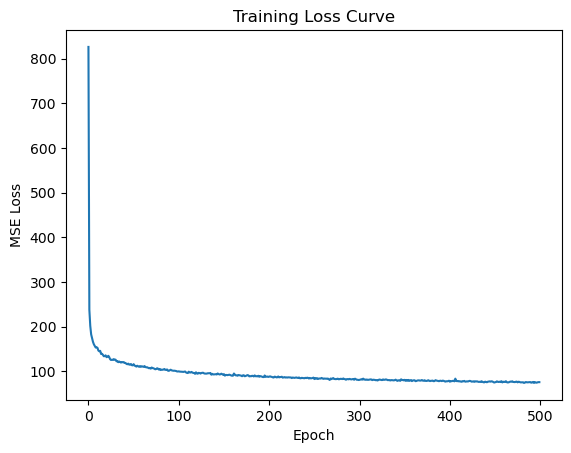

In [68]:
plt.plot(loss_dict[1]["training_loss"])
plt.title("Training Loss Curve")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.show()

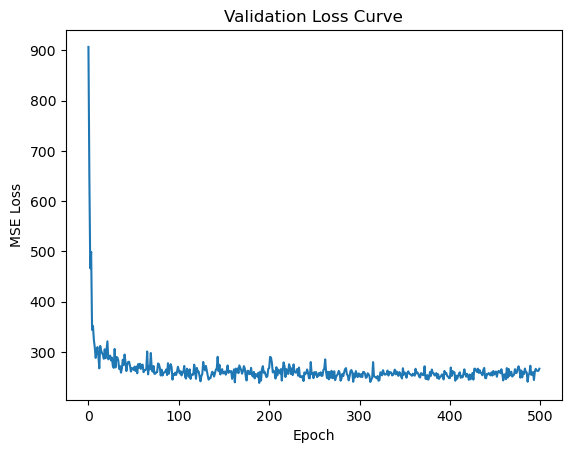

In [69]:
plt.plot(loss_dict[1]["validation_loss_list"])
plt.title("Validation Loss Curve")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.show()

In [100]:
def get_filtered_data():
    X, y, groups, activities = pp.preprocessing(n_epochs=None)
    X = X[:, 0, :]
    X, y, groups, activities = create_temporal_pairs(X, y, groups, activities)
    return X, y, groups, activities

def get_unfiltered_data():
    X, y, groups, activities = p.preprocessing(None, Config())
    X = X[:, 0, :]
    X, y, groups, activities = create_temporal_pairs(X, y, groups, activities)
    return X, y, groups, activities

In [ ]:
X, y, groups, activities  = get_filtered_data()
X_uf, y_uf, groups_uf, activities_uf  = get_unfiltered_data()
print("\n\nFiltered data shape: ", X.shape, y.shape, groups.shape, activities.shape)
print("Unfiltered data shape: ", X_uf.shape, y_uf.shape, groups_uf.shape, activities_uf.shape)

Training data shape: (64682, 4, 256), Test data shape: (64682, 1), Groups shape: (64682,), Activity shape: (64682, 1)


Filtered data shape:  (64667, 1, 256, 2) (64667, 1) (64667,) (64667,) 

Unfiltered data shape:  (64667, 256, 2) (64667, 1) (64667,) (64667, 1)


In [102]:
def get_data_loader_by_group_activity(X, y, groups, activities, group, activity):
    X = X[(groups == group) & (activities == activity)]
    y = y[(groups == group) & (activities == activity)]
    inference_data_loader = create_dataloaders(X, y, batch_size=1)
    return inference_data_loader

def perform_model_inference(dataload, model):
    model.eval()
    y_truth_arr, y_pred_arr = [], []
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(dataload):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = best_model(X_batch[..., 0], X_batch[..., 1])
            y_truth_arr.append(y_batch[0][0].cpu().numpy())
            y_pred_arr.append(y_pred[0][0].cpu().numpy())
            
    return y_truth_arr, y_pred_arr
    

100%|██████████| 317/317 [00:01<00:00, 181.45it/s]


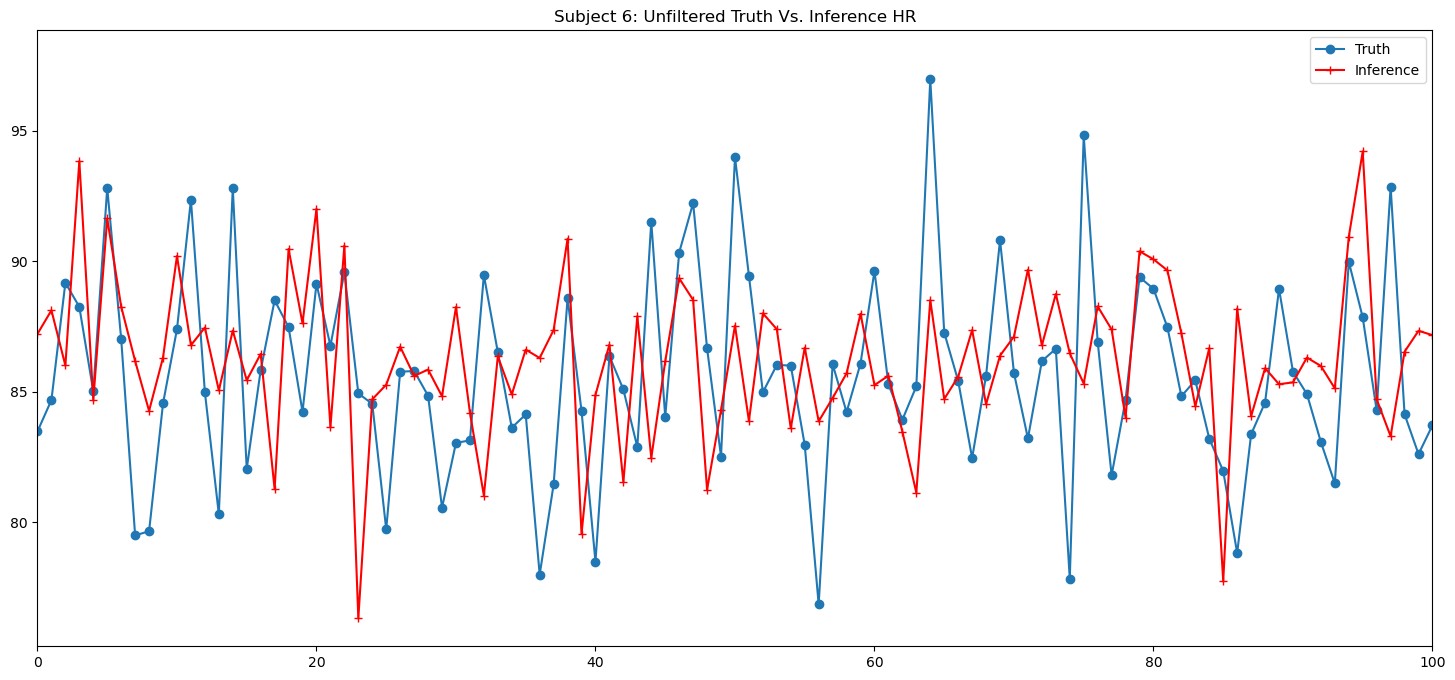

In [129]:
# Unfiltered Plot
test_subject = 6
s6_walking_data_loader = get_data_loader_by_group_activity(
    X_uf[:, None, :, :], 
    y_uf, 
    groups_uf, 
    activities_uf.flatten(), 
    test_subject, 
    activity_dict["Sitting"]
)
y_truth_arr, y_pred_arr = perform_model_inference(s6_walking_data_loader, best_model)

fig = plt.figure(figsize=(18, 8))
plt.plot(y_truth_arr, "-o", label = "Truth")
plt.plot(y_pred_arr, "-+r", label = "Inference")
plt.title("Subject 6: Unfiltered Truth Vs. Inference HR")
plt.xlim(0, 100)
plt.legend()
plt.show()

100%|██████████| 317/317 [00:01<00:00, 175.24it/s]


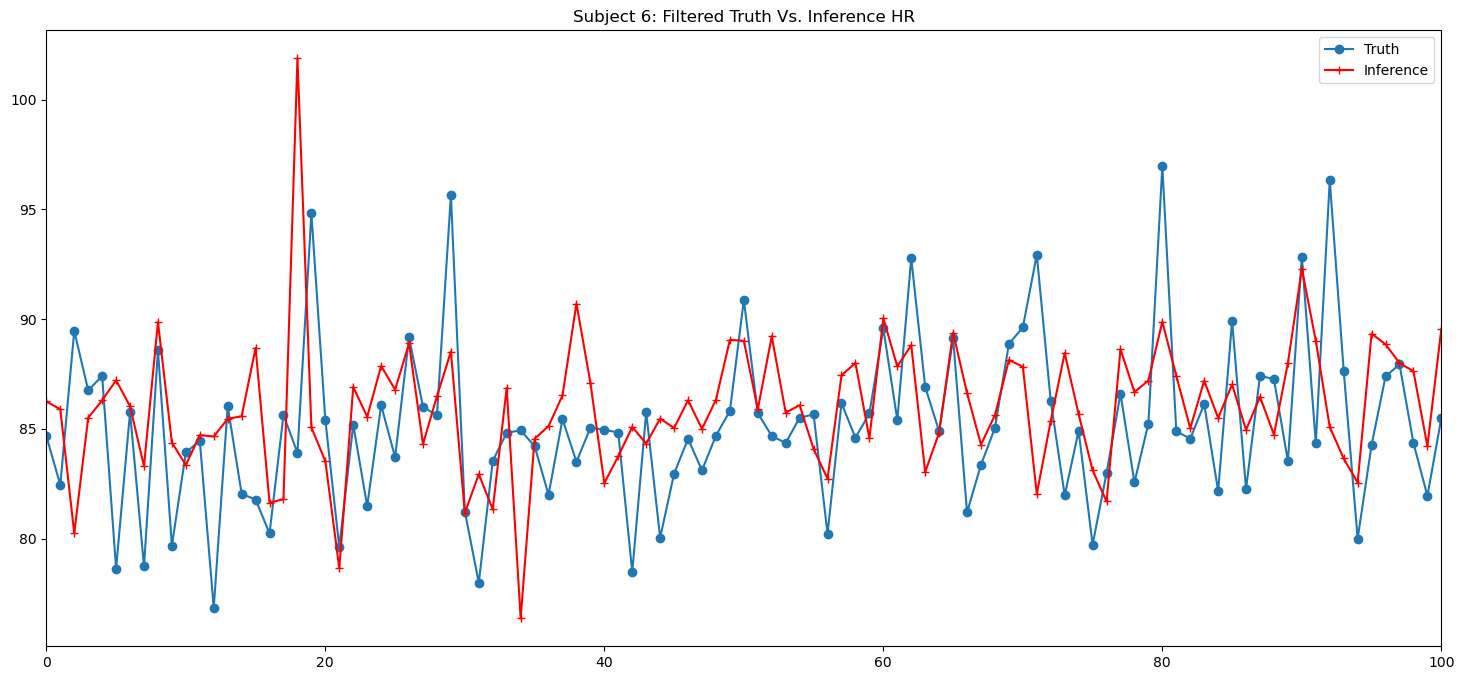

In [131]:
# Filtered Plot
s6_walking_data_loader = get_data_loader_by_group_activity(
    X, 
    y, 
    groups, 
    activities, 
    test_subject, 
    activity_dict["Sitting"]
)
y_truth_arr, y_pred_arr = perform_model_inference(s6_walking_data_loader, best_model)

fig = plt.figure(figsize=(18, 8))
plt.plot(y_truth_arr, "-o", label = "Truth")
plt.plot(y_pred_arr, "-+r", label = "Inference")
plt.title("Subject 6: Filtered Truth Vs. Inference HR")
plt.xlim(0, 100)
plt.legend()
plt.show()

# How to load the model for use and example how to use

In [ ]:
# How initial model was saved

MODEL_PATH = r"C:\Users\sheik\Documents\School\GeorgiaTech\3_2024Fall\DL\KID-PPG\src\saved_models\best_model.pth"
torch.save(best_model.state_dict(), MODEL_PATH)

In [ ]:
# How to load weights to new model

new_best_model = KID_PPG(None)
new_best_model.load_state_dict(torch.load(MODEL_PATH))

C:\Users\sheik\AppData\Local\Temp\ipykernel_18364\3576080932.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_best_model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

100%|██████████| 317/317 [00:01<00:00, 178.87it/s]


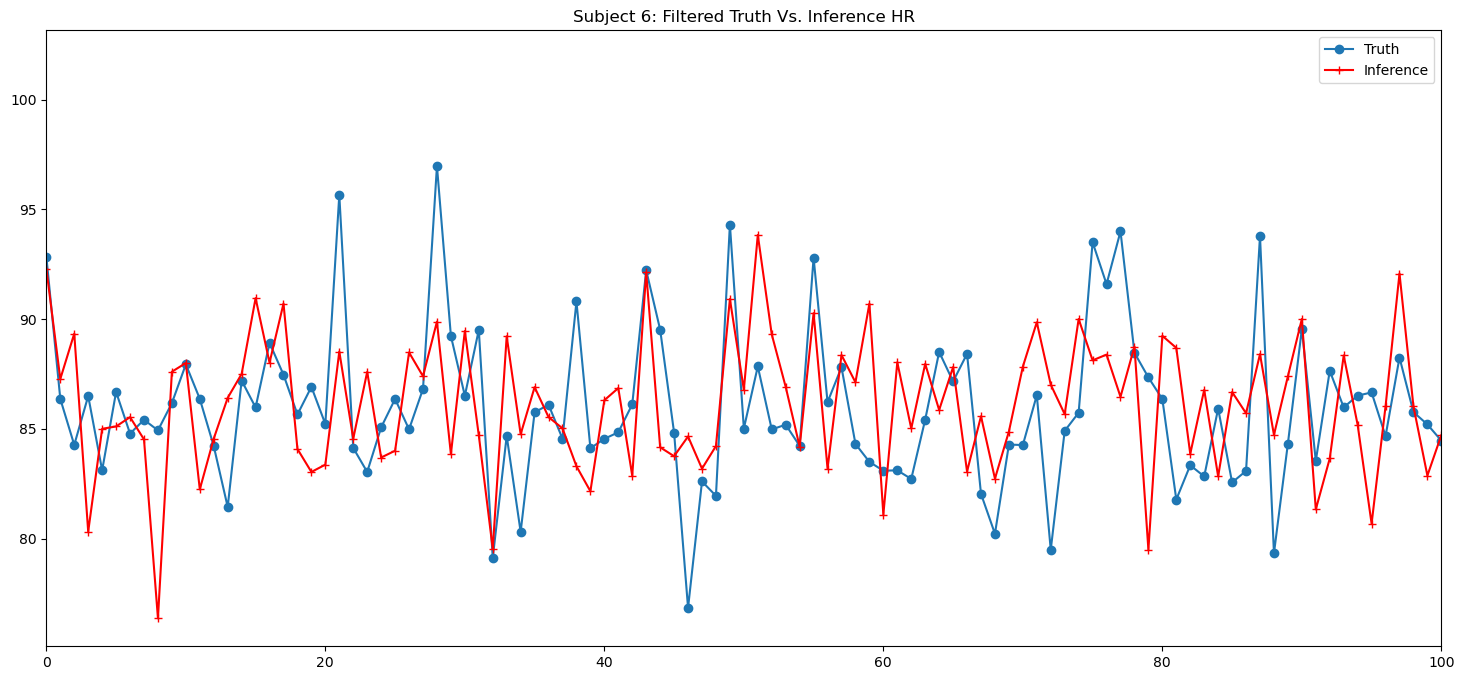

In [ ]:
# Generate inference with new plots

s6_walking_data_loader = get_data_loader_by_group_activity(
    X, 
    y, 
    groups, 
    activities, 
    test_subject, 
    activity_dict["Sitting"]
)
y_truth_arr, y_pred_arr = perform_model_inference(s6_walking_data_loader, new_best_model) # The new best model is here

fig = plt.figure(figsize=(18, 8))
plt.plot(y_truth_arr, "-o", label = "Truth")
plt.plot(y_pred_arr, "-+r", label = "Inference")
plt.title("Subject 6: Filtered Truth Vs. Inference HR")
plt.xlim(0, 100)
plt.legend()
plt.show()